In [1]:
from torchvision.models import vgg16
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from torchsummary import summary
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.nn.functional as F
import copy


%matplotlib inline

# G-Drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# DATA_PATH = r"/content/drive/My Drive/MLLAB_Project_3/data"
# N_SAMPLES = 100

# Load data and extract features with VGG

## Load data

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

False


In [4]:
DATA_PATH = r"./data"
N_SAMPLES = 10

dataset = datasets.ImageFolder(DATA_PATH, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True)

images, labels = next(iter(dataloader))
labels = 1 - labels # disease = 1, healthy = 0
print(images.shape)
print(labels.shape)

torch.Size([1000, 3, 256, 256])
torch.Size([1000])


Plot an image

torch.Size([1000, 3, 256, 256])
tensor(1)


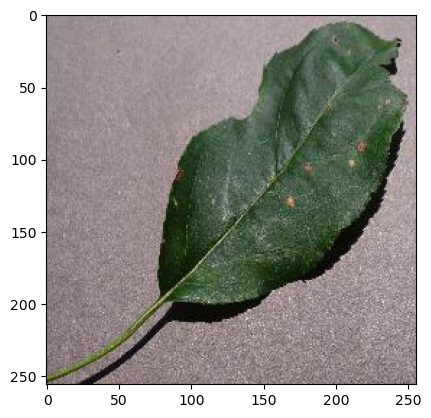

In [5]:
print(images.shape)
image = images[0]
print(labels[0])
plt.imshow(torch.permute(image, (1, 2, 0)))
plt.show()

## Get subsample

In [6]:
torch.cuda.empty_cache()

In [7]:
# sample N_SAMPLES images from each class
images_0, labels_0 = images[labels == 0][:N_SAMPLES], labels[labels == 0][:N_SAMPLES]
images_1, labels_1 = images[labels == 1][:N_SAMPLES], labels[labels == 1][:N_SAMPLES]

In [8]:
print(images_0.shape)
X = torch.cat((images_0, images_1), dim=0).to(device)
y = torch.cat((labels_0, labels_1), dim=0)
print(X.shape)
print((y == 1).sum())


torch.Size([10, 3, 256, 256])
torch.Size([20, 3, 256, 256])
tensor(10)


## Load model

In [9]:
vgg16_model = vgg16(pretrained=True, progress=True)
vgg16_model.features.append(torch.nn.Flatten(start_dim=1))
model = vgg16_model.features.to(device)

model.eval()

c:\Users\musta\anaconda3\envs\MLLAB\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\musta\anaconda3\envs\MLLAB\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [10]:
# # Es kommt drauf an, ob man nen Batch an Daten nimmt oder nur eine Instanz! [wegen Flatten layer start_dim!!]
# print("batch Image shape", X.size())
# print("Image shape", X[0].size())
# summary(model, (3, 256, 256))

## Transform features with model

In [11]:
with torch.no_grad():
    torch.cuda.empty_cache()
    X_representation = model(X)

## Train-Test split

In [12]:
# split data into train and test with sklearn
X_train, X_test, y_train, y_test = train_test_split(X_representation, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
print(X_train.shape)

torch.Size([16, 32768])


# Predicting classes from images

## Fit the model

In [13]:
# # fit model
images_0_train = X_train[y_train == 0]
images_1_train = X_train[y_train == 1]
mean_0 = images_0_train.sum(dim=0) / images_0_train.size(0)
mean_1 = images_1_train.sum(dim=0) / images_1_train.size(0)
mean_difference = mean_1 - mean_0
w = mean_difference / mean_difference.norm()
print(w.size())
print(w.get_device(), X_train.get_device())

torch.Size([32768])
-1 -1


## Predict Scores

In [14]:
pred_scores_train = torch.matmul(X_train, w.T).to("cpu")
pred_probabilities_train = torch.sigmoid(pred_scores_train).to("cpu")

pred_scores_test = torch.matmul(X_test, w.T).to("cpu")
pred_probabilities_test = torch.sigmoid(pred_scores_test).to("cpu")

C:\Users\musta\AppData\Local\Temp\ipykernel_7336\399288679.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3575.)
  pred_scores_train = torch.matmul(X_train, w.T).to("cpu")


# AUC

In [15]:
print(y_train.get_device())
print(pred_probabilities_train.get_device())

-1
-1


ROC AUC Score train:  1.0
ROC AUC Score test:  1.0


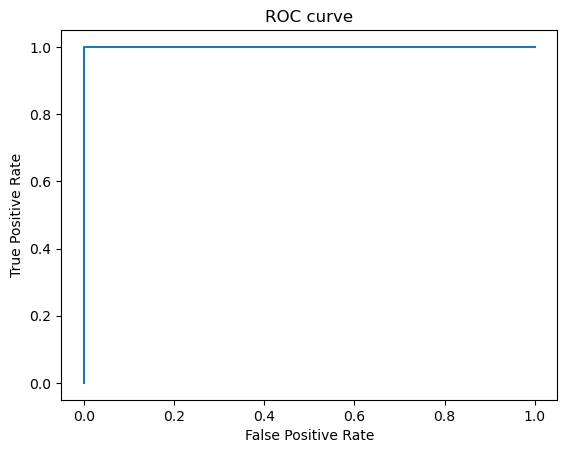

[2.         1.         0.55476534]


In [16]:
print("ROC AUC Score train: ", roc_auc_score(y_train, pred_probabilities_train))
print("ROC AUC Score test: ", roc_auc_score(y_test, pred_probabilities_test))
# plot a auc curve

fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities_test)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()
print(thresholds)

# Dumpster

In [17]:
# roc_auc_score(true_labels, pred_probabilities)
# # plot a auc curve
# from sklearn.metrics import roc_curve
# fpr, tpr, thresholds = roc_curve(true_labels, pred_probabilities)
# plt.plot(fpr, tpr)
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC curve')
# plt.show()
# print(thresholds)

In [18]:
## Get Layers manually approach

# features = torch.nn.ModuleList(vgg16_model.features.children())
# model_features = torch.nn.Sequential(*features)
# some_more_layers = torch.nn.Sequential(torch.nn.Flatten(start_dim=1))

# model_1 = torch.nn.Sequential(model_features,
#                       some_more_layers)
# model_1.eval()
# summary(model_1, (3, 256, 256))
# print(model_1(images_0).size())

In [19]:
# Flatten not as part of model approach

# billo = vgg16_model.features
# billo.eval()
# summary(billo, (3, 256, 256))
# print("input size", images_0[0].size())
# rep = billo(images_0[0])
# print("output size", rep.size())
# torch.nn.Flatten(start_dim=0)(rep).size()
# # apply model on images_0

In [20]:
# billo = vgg16_model.features
# billo.eval()
# rep = billo(images_0)
# print("input size", rep.size())
# torch.nn.Flatten(start_dim=1)(rep).size()

# Sensitivity Analysis

In [21]:
torch.cuda.empty_cache()

In [22]:
print(X_train.size())

torch.Size([16, 32768])


In [23]:
w_layer = torch.nn.Linear(32768, 1, bias=False)

# add weight layer to model to get mean difference model
model_diff = model.append(w_layer).to(device)

model_diff.eval()

with torch.no_grad():
    model_diff[-1].weight = torch.nn.Parameter(w)

print((model_diff[-1].weight == w).all())
print(model_diff[-1].weight)

tensor(True)
Parameter containing:
tensor([ 0.0045, -0.0009,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
       requires_grad=True)


tensor([0.2199], grad_fn=<MvBackward0>)


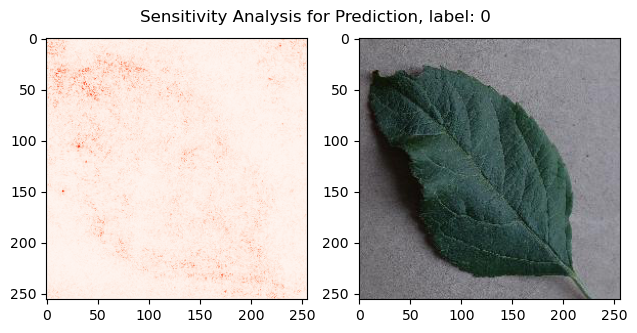

In [24]:
img_id = 8
img = images[img_id]
input_data = torch.autograd.Variable(img.unsqueeze(0), requires_grad=True).to(device)
output = model_diff(input_data)
print(output)
output.backward()  # Backward pass with a gradient of ones torch.ones_like(output)
gradients = input_data.grad
sensitivity = gradients.norm(dim=1)

# plot to images 
fig, axs = plt.subplots(1,2)

axs[0].imshow(sensitivity.squeeze(0), cmap="Reds")
axs[1].imshow(torch.permute(images[img_id], (1, 2, 0)))
fig.suptitle(f"Sensitivity Analysis for Prediction, label: {labels[img_id]}", y=0.8)
plt.tight_layout()
plt.show()

In [25]:
sensitivity

tensor([[[0.0285, 0.0222, 0.0198,  ..., 0.0577, 0.0244, 0.0168],
         [0.0824, 0.1083, 0.1681,  ..., 0.0745, 0.0629, 0.0201],
         [0.0206, 0.0586, 0.2058,  ..., 0.0680, 0.0684, 0.0314],
         ...,
         [0.0461, 0.0567, 0.1600,  ..., 0.0364, 0.0393, 0.0153],
         [0.0402, 0.0456, 0.0593,  ..., 0.0115, 0.0036, 0.0377],
         [0.0203, 0.0289, 0.0260,  ..., 0.0110, 0.0128, 0.0062]]])

# More robust explanations

In [26]:
class BiasedLayer(torch.nn.Module):
    # TODO: understand what BiasedLayer is supposed to be/understand notation
    def __init__(self, ConvLayer):
        super().__init__()
        self.og_conv = copy.deepcopy(ConvLayer)
        self.og_weight = self.og_conv.weight
        self.og_bias = self.og_conv.bias

        self.og_conv.weight.requires_grad = False
        self.og_conv.bias.requires_grad = False
        self.biased_conv = copy.deepcopy(ConvLayer)
        self.biased_conv.weight = torch.nn.Parameter(self.og_weight + (0.25 * torch.maximum(torch.zeros_like(self.og_weight), self.og_weight)))
        self.biased_conv.bias = torch.nn.Parameter(self.og_bias + (0.25 * torch.maximum(torch.zeros_like(self.og_bias), self.og_bias)))


    def forward(self, X):
        biased_out = self.biased_conv(X)
        with torch.no_grad():
            self.og_conv.weight = torch.nn.Parameter(self.og_weight / biased_out.sum())
            self.og_conv.bias = torch.nn.Parameter(self.og_bias / biased_out.sum())

        return biased_out * self.og_conv(X)

In [27]:
# test biased layer with a tensor

# create Conv2d layer
test_conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=1, padding=0, bias=True)
test_conv.weight = torch.nn.Parameter(torch.tensor([[[[1., 1., 1.],
                                                        [1., 1., 1.],
                                                        [1., 1., 1.]]]]))
test_conv.bias = torch.nn.Parameter(torch.tensor([1.]))

# Convert it to BiasedLayer instance
test = BiasedLayer(test_conv)
# Check if the weights and biases are freezed for parts of the model
print(test.biased_conv.bias.requires_grad)
print(test.og_conv.bias.requires_grad)

# Create Artificial Input
input_data = torch.tensor([[[[1., 1., 1.],
                            [1., 1., 1.],
                            [1., 1., 1.]]]], requires_grad=True)

# Run forward pass and retrieve sensitivity
output = test(input_data)
print(output)
output.backward()  # Backward pass with a gradient of ones torch.ones_like(output)
gradients = input_data.grad
sensitivity = gradients.norm(dim=1)
sensitivity

True
False
tensor([[[[10.0000]]]], grad_fn=<MulBackward0>)


tensor([[[2., 2., 2.],
         [2., 2., 2.],
         [2., 2., 2.]]])

In [28]:
output = test_conv(input_data)
print(output)
output.backward()  # Backward pass with a gradient of ones torch.ones_like(output)
gradients = input_data.grad
sensitivity = gradients.norm(dim=1)
sensitivity

tensor([[[[10.]]]], grad_fn=<ConvolutionBackward0>)


tensor([[[3., 3., 3.],
         [3., 3., 3.],
         [3., 3., 3.]]])

# Customize all layers from VGG

In [29]:
# check if is a torch conv2d layer
print(isinstance(test_conv, torch.nn.Conv2d))

end_model = nn.Sequential()
i = 0
for layer in model_diff.children():
    if isinstance(layer, torch.nn.Conv2d) & (i != 0): # last linear layer is not considered by default
        #print("Esel")
        biased_layer = BiasedLayer(layer)
        #print(biased_layer.biased_conv.bias)
        end_model.append(biased_layer)
        #print(list(end_model.children())[-1].biased_conv.bias)
        #print(end_model[-1].biased_conv.bias)
    else:
        #print("Hund")
        end_model.append(layer)
    i = 1

end_model.to(device)

True


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BiasedLayer(
    (og_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (biased_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): BiasedLayer(
    (og_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (biased_conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (6): ReLU(inplace=True)
  (7): BiasedLayer(
    (og_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (biased_conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): BiasedLayer(
    (og_conv): Conv2d(128, 256, kernel_size=(3, 3),

In [30]:
print(end_model[2].og_conv.bias.size())
print(end_model[2].biased_conv.bias.size())
print(model_diff[2].bias.size())
(end_model[2].og_conv.bias == model_diff[2].bias).all()
#end_model[2]
#example_biased_layer = BiasedLayer(example_layer)
#example_biased_layer.biased_conv.bias == example_biased_layer.og_conv.bias

torch.Size([64])
torch.Size([64])
torch.Size([64])


tensor(True)

In [31]:
img_id = 0
img = images[img_id]
input_data = torch.autograd.Variable(img.unsqueeze(0), requires_grad=True).to(device)
output = end_model(input_data)
print(output)
output.backward(torch.ones_like(output) * 10)  # Backward pass with a gradient of ones torch.ones_like(output)
gradients = input_data.grad
sensitivity = gradients.norm(dim=1)
print(sensitivity)
print(sensitivity.sum())

tensor([7.8549e-05], grad_fn=<MvBackward0>)
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor(0.)


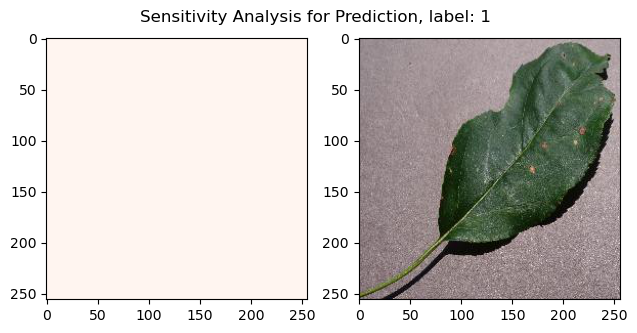

In [32]:
# plot to images 
fig, axs = plt.subplots(1,2)

axs[0].imshow(sensitivity.squeeze(0), cmap="Reds")
axs[1].imshow(torch.permute(images[img_id], (1, 2, 0)))
fig.suptitle(f"Sensitivity Analysis for Prediction, label: {labels[img_id]}", y=0.8)
plt.tight_layout()
plt.show()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
pred_scores_test = end_model(X_test)
pred_probabilities_test = torch.sigmoid(pred_scores_test).to("cpu")

In [37]:
roc_auc_score(y_test, pred_probabilities_test.detach().numpy()) # miese Zeiten

0.5